# Support Center Queue

Jill manages a software support center.  Jill wants to run an analysis on how long support requests remain in the system before getting resolved.  Collecting some stats and showing a Histogram of request time in system seems like a nice outcome.  Jill has data of when each request enters the system, and when each request is resolved.  

One methodology is to gather various Scenarios for which to analyze.  For example, a Busy Post Launch Scenario, a Mild Scenario,  A Monday Morning Scenario, etc.   And then use these scenarios to plan staffing, etc.

To test her methodology and code, she will use the following small dataset and make the following assumptions:

- Jobs arrive, are processed, and complete only at integral units of minutes
- Request arrival times:  `0, 5, 10, 12, 14, 15, 55`
- So, the time between arrivals is `5, 5, 2, 2, 1, 40`
- Service times for each request, that is, time to resolve once started: `4, 4, 10, 10, 10, 10, 1`
- There is a single support staff that processes requests First-In-First-Out (FIFO)

In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source
from pprint import pprint




In [2]:
"""
These generators define interarrival times and service times
"""
def interarrival_time_generator():
    interarrival_times = [0,5,5,2,2,1,40]
    for time in interarrival_times:
        yield time
        
def call_center_service_time_generator():
    service_times = [4,4,10,10,10,10,1]
    for time in service_times:
        yield time   

In [3]:
def dispose(entity):
    return lambda _: entity.dispose() 

def call_center(env, entity, resource):
    """
    defines the set of steps necessary for processing an
    entity in a call center
    """
    request = entity.request_resource(resource)
    print(f'{entity.name} started processing: {env.now}')
    yield request
    print(f'{entity.name} started processing: {env.now}')
    entity.start_service_at_resource(resource)
#   resource.process_request(entity, request) # this is useful for when we want to move this logic into a resource subclass
    yield env.timeout(next(resource.service_time_generator))
    print(f'{entity.name} finished processing: {env.now}')
    entity.release_resource(resource, request)
    return entity


def process(env, source, resource):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     number: number of jobs to generate
     res: Shared resource
     
    """
    
    for arrival_time, entity in source.next_entity():
        yield arrival_time
        processed_entity = env.process(call_center(env, entity, resource))
        processed_entity.callbacks.append(dispose(entity))
                

In [4]:
class CallCenter(Resource):
    def process_entity(self, entity):
        print(f"processing entity with name {entity.name}")
    
        
# Setup and start the simulation
print('Support Center 1\n')
env = simpy.Environment()

source = Source(env, Entity, interarrival_time_generator)
# Start processes and run
resource = Resource(env, name="call_center", capacity=1, service_time_generator=call_center_service_time_generator)
env.process(process(env, source, resource))
env.run()

Support Center 1

job_0 requested call_center: 0
job_0 started processing call_center: 0
job_0 finished processing call_center: 4
job_0 disposed: 4
job_5 requested call_center: 5
job_5 started processing call_center: 5
job_5 finished processing call_center: 9
job_5 disposed: 9
job_10 requested call_center: 10
job_10 started processing call_center: 10
job_12 requested call_center: 12
job_14 requested call_center: 14
job_15 requested call_center: 15
job_10 finished processing call_center: 20
job_10 disposed: 20
job_12 started processing call_center: 20
job_12 finished processing call_center: 30
job_12 disposed: 30
job_14 started processing call_center: 30
job_14 finished processing call_center: 40
job_14 disposed: 40
job_15 started processing call_center: 40
job_15 finished processing call_center: 50
job_15 disposed: 50
job_55 requested call_center: 55
job_55 started processing call_center: 55
job_55 finished processing call_center: 56
job_55 disposed: 56


In [5]:
"""
Statistics collected by entities that passed through system
"""
system_time = source.get_total_times()
print(source.get_total_times())
print(source.get_waiting_times())
print(source.get_processing_times())

[4, 4, 10, 18, 26, 35, 1]
[0, 0, 0, 8, 16, 25, 0]
[4, 4, 10, 10, 10, 10, 1]


In [6]:
"""
Statistics collected by resource
"""
print(resource.queue_size_over_time())
resource.process_entity({})

[(0, 0, 'request'), (4, 0, 'release'), (5, 0, 'request'), (9, 0, 'release'), (10, 0, 'request'), (12, 1, 'request'), (14, 2, 'request'), (15, 3, 'request'), (20, 3, 'release'), (30, 2, 'release'), (40, 1, 'release'), (50, 0, 'release'), (55, 0, 'request'), (56, 0, 'release')]


NotImplementedError: Implement this method

In [25]:
print('The average system time is:',np.mean(system_time))

The average system time is: 14.0


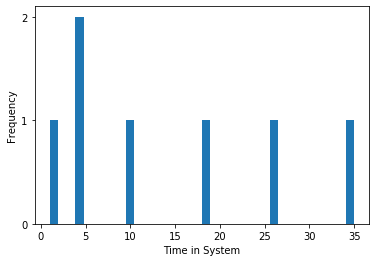

In [26]:
# Tinker with number of bins, until it looks right
plt.hist(system_time,bins=36)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

## The NumPy package provides lots of statistical methods, we call it with `np`

In [27]:
np.max(system_time)

35

In [28]:
# 50th percentile, or median
np.percentile(system_time,50)

10.0

In [29]:
np.median(system_time)

10.0

In [30]:
np.std(system_time)

11.868325191750639

# Support Center: Homework/Class work

Add to this notebook to answer the following:

1. Consider the number of jobs in the queue over time, from 0 until all jobs are completed
  - What is the average number of jobs in the queue?
  - Form a histogram of the number of jobs in the queue

1. Consider the time jobs spend in the queue, before beginning service.
  - What is the average time a job spends in the queue?
  - Form a histogram of the time jobs spend in the queue
  
